In [136]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import math
import time
import random

# VISUALIZATION
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from pycaret.classification import *
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [137]:
os.chdir(r'/home/grejell/Projects/arab-bank-test-churn-analysis')

In [138]:
cleanData = pd.read_pickle('./data/cleanData.pkl')

In [139]:
cleanData.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,1,29.85,29.85,1,0,0,1,1,0,...,1,0,0,0,1,0,0,1,0,0
1,0,34,56.95,1889.50,0,1,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0
2,0,2,53.85,108.15,0,1,1,0,1,0,...,1,0,0,0,1,0,0,0,1,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,...,0,1,0,1,0,1,0,0,0,0
4,0,2,70.70,151.65,1,0,1,0,1,0,...,1,0,0,0,1,0,0,1,0,1


In [141]:
clf1 = setup(cleanData, target = 'Churn_Yes')

best = compare_models(sort='F1')

best

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Quadratic Discriminant Analysis,0.7442,0.8301,0.7478,0.5145,0.6089,0.4288,0.4458,0.0109
1,Naive Bayes,0.6902,0.8106,0.8380,0.4560,0.5903,0.3749,0.4199,0.0059
2,Ada Boost Classifier,0.7976,0.8367,0.5307,0.6477,0.5810,0.4498,0.4552,0.2509
3,Logistic Regression,0.7995,0.8362,0.5215,0.6541,0.5787,0.4498,0.4556,0.0560
4,Linear Discriminant Analysis,0.7918,0.8302,0.5330,0.6277,0.5749,0.4386,0.4421,0.0262
5,Gradient Boosting Classifier,0.7983,0.8396,0.5024,0.6589,0.5684,0.4403,0.4481,0.8027
6,Light Gradient Boosting Machine,0.7899,0.8248,0.5146,0.6296,0.5648,0.4285,0.4332,0.1309
7,CatBoost Classifier,0.7936,0.8316,0.5016,0.6436,0.5625,0.4305,0.4369,3.3231
8,Extreme Gradient Boosting,0.7826,0.8135,0.5154,0.6097,0.5569,0.4145,0.4182,0.7863
9,Ridge Classifier,0.7934,0.0000,0.4841,0.6482,0.5516,0.4220,0.4307,0.0083


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

#### Try to improve the model by tuning the tree-based algorithms

In [151]:
def split_data(data):
    data = data.rename(columns={'Churn_Yes': 'labels'})
    dataX = data.drop(['labels'], axis = 1)
    dataY = data['labels']
    
    # Create train and test dataset
    X_train, x_test, Y_train, y_test = train_test_split(dataX, dataY, random_state = 0)
    return X_train, x_test, Y_train, y_test

X_train, x_test, Y_train, y_test = split_data(cleanData)

In [152]:
print(len(X_train))
print(len(x_test))

5274
1758


In [ ]:
def bayes_parameter_opt_lgb(X_train, Y_train, init_round=300, n_folds=5, random_seed=23, n_estimators=500, learning_rate=0.01, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X_train, label=Y_train, free_raw_data=False)

    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'application':'binary', 'learning_rate':0.1, 'metric':'binary_logloss', 'boosting_type':'gbdt'}
        params['num_leaves'] = round(num_leaves).astype(int)
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = round(max_depth).astype(int)
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =0, metrics=['binary_logloss'])
        # print(cv_result)
        return max(cv_result['binary_logloss-mean'])*(-1)

    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (5, 15),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.5, 1),
                                            'max_depth': (50, 100),
                                            'lambda_l1': (0, 3),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 1),
                                            'min_child_weight': (0.001, 1)}, random_state=0)
    
    lgbBO.maximize(init_points=init_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv(".\data\lgbmbayes_opt_result.csv")
   
    # get the best parameters
    optimData = pd.DataFrame(lgbBO.res)
    optim = list(optimData[optimData['target'] == optimData['target'].max()]['params'])
    print('\n')
    print('\n')
    print(optim)
    # return best parameters
    return optim

optim = bayes_parameter_opt_lgb(X_train, Y_train, init_round=500, n_folds=5, random_seed=23, n_estimators=500)

In [161]:
def train_model(X_train, Y_train):
    d_train = lgb.Dataset(X_train, label=Y_train)
    params = {'bagging_fraction': 0.8170271543581233, 
              'feature_fraction': 0.8944204959702969, 
              'lambda_l1': 0.28619379229653075, 
              'lambda_l2': 0.48522674884857864, 
              'max_depth': round(6.598398782224825), 
              'min_child_weight': 5.280224224932782, 
              'min_split_gain': 0.05242715514027915, 
              'num_leaves':round(37.42221384033454)}
    params['learning_rate'] = 0.001
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'binary'
    params['metric'] = 'binary_logloss'
    lgbmodel = lgb.train(params, d_train, 5000, verbose_eval=True)
    return lgbmodel, params

lgbmodel, parameters = train_model(X_train, Y_train)

In [162]:
def predict_data(X, Y, data_type):
    ## predicting test data
    y_pred = lgbmodel.predict(X)
    y_pred_prob = lgbmodel.predict(X)
    for i in range(len(X)):
        if y_pred[i]>=.5: 
           y_pred[i]=1
        else:  
           y_pred[i]=0

    #print accuracy_score(y_test, predicted) for test data
    accuracy = metrics.accuracy_score(y_pred, Y)
    print('\n\n\nThe following are metrices for ', data_type, ' data')
    print('='*50)
    print('='*50)
    preds = pd.DataFrame({'true': Y, 'predicted': y_pred})
    confusion = pd.crosstab(preds['predicted'], preds['true'])
    print('='*50)
    print('\n CONFUSION MATRIX:\n', confusion)
    precision = metrics.precision_score(Y, y_pred)
    print('='*50)
    print('\n', data_type ,'ACCURACY ' + accuracy.astype(str))
    print('\n', data_type ,'PRECISION ' + precision.astype(str))
    recall = metrics.recall_score(Y, y_pred)
    print('\n', data_type ,'RECALL ' + recall.astype(str))
    f1_score = metrics.f1_score(Y, y_pred)
    print('\n', data_type ,'F1 SCORE ' + f1_score.astype(str))
    
    fpr, tpr, thresholds = metrics.roc_curve(Y, y_pred)
    auc_score = metrics.auc(fpr, tpr)
    
    print('\n', data_type ,'AUC ' + auc_score.astype(str))
    print('='*50)
    return y_pred, y_pred_prob, accuracy, precision, recall

y_pred_train,y_pred_prob,_,_,_ = predict_data(X_train, Y_train, data_type='TRAIN')
y_pred_test, y_pred_prob_test, accuracy, precision, recall = predict_data(x_test, y_test, data_type='TEST')




The following are metrices for  TRAIN  data

 CONFUSION MATRIX:
 true          0    1
predicted           
0.0        3574  534
1.0         278  888

 TRAIN ACCURACY 0.8460371634433068

 TRAIN PRECISION 0.7615780445969125

 TRAIN RECALL 0.6244725738396625

 TRAIN F1 SCORE 0.6862442040185471

 TRAIN AUC 0.7761511363486993



The following are metrices for  TEST  data

 CONFUSION MATRIX:
 true          0    1
predicted           
0.0        1192  221
1.0         119  226

 TEST ACCURACY 0.8065984072810012

 TEST PRECISION 0.6550724637681159

 TEST RECALL 0.5055928411633109

 TEST F1 SCORE 0.5707070707070706

 TEST AUC 0.7074112184458813


In [157]:
traindata_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)
testdata_dmatrix = xgb.DMatrix(data=x_test,label=y_test)

In [51]:
import xgboost as xgb

In [ ]:
def bayes_parameter_opt_xgboost(X_train, Y_train, init_round=100, n_folds=5, random_seed=23, learning_rate=0.01, output_process=False):
    # prepare data
    traindata_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)

    def xgboost_eval(colsample_bytree, subsample, max_depth, gamma, n_estimators, min_child_weight, reg_alpha):
        params = {'objective':'binary:logistic', 'learning_rate':0.01, 'metric':'binary_logloss'}
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['subsample'] = max(min(subsample, 1), 0)
        params['max_depth'] = round(max_depth).astype(int)
        params['gamma'] = max(gamma, 0)
        params['n_estimators'] = int(n_estimators)
        params['min_child_weight'] = round(min_child_weight).astype(int)
        params['reg_alpha'] = reg_alpha
        
        cv_result = xgb.cv(dtrain=traindata_dmatrix, params=params, nfold=5,early_stopping_rounds=100, as_pandas=True, seed=23)

#         print(cv_result)
        return max(cv_result['train-error-mean'])*-1

    xgbBO = BayesianOptimization(xgboost_eval, {
                                            'colsample_bytree': (0.1, 0.9),
                                            'subsample': (0.5, 1),
                                            'max_depth': (5, 10),
                                            'gamma': (0, 1),
                                            'n_estimators':(100,500),
                                            'min_child_weight':(6,20),
                                            'reg_alpha':(1e-5,100)}, random_state=23)
    
    xgbBO.maximize(init_points=init_round)
    
    # output optimization process
    if output_process==True: xgbBO.points_to_csv("./data\/xgb_bayes_opt_result.csv")
   
    # get the best parameters
    optimData = pd.DataFrame(xgbBO.res)
    optim = list(optimData[optimData['target'] == optimData['target'].max()]['params'])
    print('\n')
    print('\n')
    print(optim)
    # return best parameters
    return optim

optim = bayes_parameter_opt_xgboost(X_train, Y_train, init_round=5000, n_folds=5, random_seed=23)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | n_esti... | reg_alpha | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.2696   |  0.5138   |  0.947    |  8.827    |  9.954    |  188.4    |  68.62    |  0.5836   |
|  2        | -0.2696   |  0.414    |  0.6181   |  7.06     |  6.035    |  453.6    |  88.49    |  0.6502   |
|  3        | -0.225    |  0.5717   |  0.9784   |  9.225    |  6.911    |  217.9    |  28.79    |  0.9112   |
|  4        | -0.2178   |  0.6009   |  0.1105   |  5.003    |  19.19    |  156.6    |  42.16    |  0.6732   |
|  5        | -0.2148   |  0.7958   |  0.4286   |  9.144    |  16.05    |  147.7    |  59.64    |  0.5649   |
|  6        | -0.2685   |  0.162    |  0.8312   |  7.322    |  8.268    |  319.2    |  58.85    |  0.8868   |
|  7        | -0.2171   |  0.6247   |  0.5577   |  5.891    |  9.368    |  302.4    |  39.67    |  0.7415   |
|  8      

In [131]:

def train_model(X_train, Y_train):
    data_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)
    params = {'colsample_bytree': 0.838864929259362, 
              'gamma': 0.592897955572043, 
              'max_depth': round(9.609719591414311),
              'min_child_weight': 6.453004555420097, 
              'n_estimators': 365.8950947740957, 
              'reg_alpha': 4.880598712155049, 
              'subsample': 0.9162287352491574,
         'objective':'binary:logistic'}
    model = xgb.train(params=params, dtrain=data_dmatrix)

    return model

xgbmodel = train_model(X_train, Y_train)

In [132]:
def predict_data(x_test, y_test, data_type):
    ## predicting test data
    data_dmatrix = xgb.DMatrix(data=x_test,label=y_test)
    y_pred = model.predict(data_dmatrix)
    y_pred_prob = model.predict(data_dmatrix)
    for i in range(len(x_test)):
        if y_pred[i]>=.5:       # setting threshold to .5
           y_pred[i]=1
        else:  
           y_pred[i]=0

    #print accuracy_score(y_test, predicted) for test data
    accuracy = metrics.accuracy_score(y_pred, y_test)
    print('\n\n\nThe following are metrices for ', data_type, ' data')
    print('='*50)
    preds = pd.DataFrame({'true': y_test, 'predicted': y_pred})
    confusion = pd.crosstab(preds['predicted'], preds['true'])
    print('='*50)
    print('\n CONFUSION MATRIX:\n', confusion)
    precision = metrics.precision_score(y_test, y_pred)
    print('='*50)
    print('\n', data_type ,'ACCURACY ' + accuracy.astype(str))
    print('\n', data_type ,'PRECISION ' + precision.astype(str))
    recall = metrics.recall_score(y_test, y_pred)
    print('\n', data_type ,'RECALL ' + recall.astype(str))
    f1_score = metrics.f1_score(y_test, y_pred)
    print('\n', data_type ,'F1 SCORE ' + f1_score.astype(str))
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc_score = metrics.auc(fpr, tpr)
    
    print('\n', data_type ,'AUC ' + auc_score.astype(str))
    print('='*50)
    return y_pred, y_pred_prob, accuracy, precision, recall

y_pred_train,y_pred_prob,_,_,_ = predict_data(X_train, Y_train, data_type='TRAIN')
y_pred_test, y_pred_prob_test, accuracy, precision, recall = predict_data(x_test, y_test, data_type='TEST')




The following are metrices for  TRAIN  data

 CONFUSION MATRIX:
 true          0    1
predicted           
0.0        3556  609
1.0         296  813

 TRAIN ACCURACY 0.8284034888130452

 TRAIN PRECISION 0.7330928764652841

 TRAIN RECALL 0.5717299578059072

 TRAIN F1 SCORE 0.6424338206242591

 TRAIN AUC 0.7474433797336909



The following are metrices for  TEST  data

 CONFUSION MATRIX:
 true          0    1
predicted           
0.0        1203  220
1.0         108  227

 TEST ACCURACY 0.8134243458475541

 TEST PRECISION 0.6776119402985075

 TEST RECALL 0.5078299776286354

 TEST F1 SCORE 0.5805626598465474

 TEST AUC 0.7127250574642033


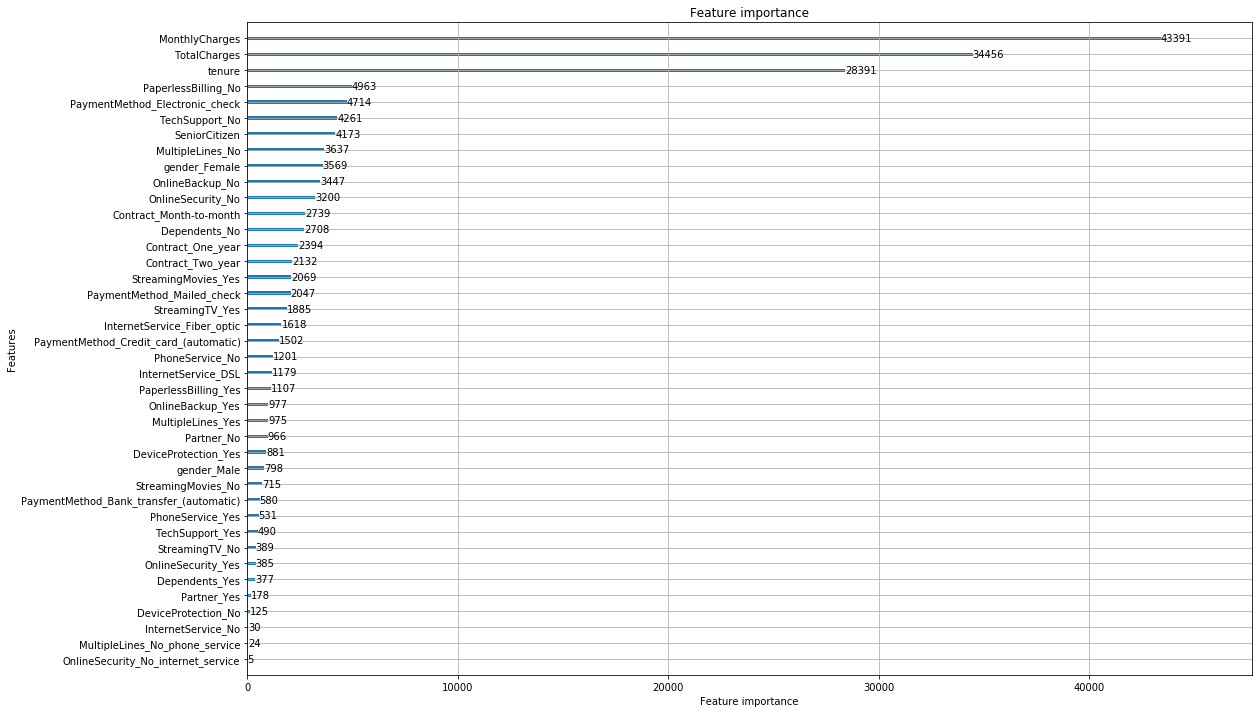

In [163]:
lgb.plot_importance(lgbmodel)
plt.rcParams['figure.figsize'] = [18, 12]
plt.show()

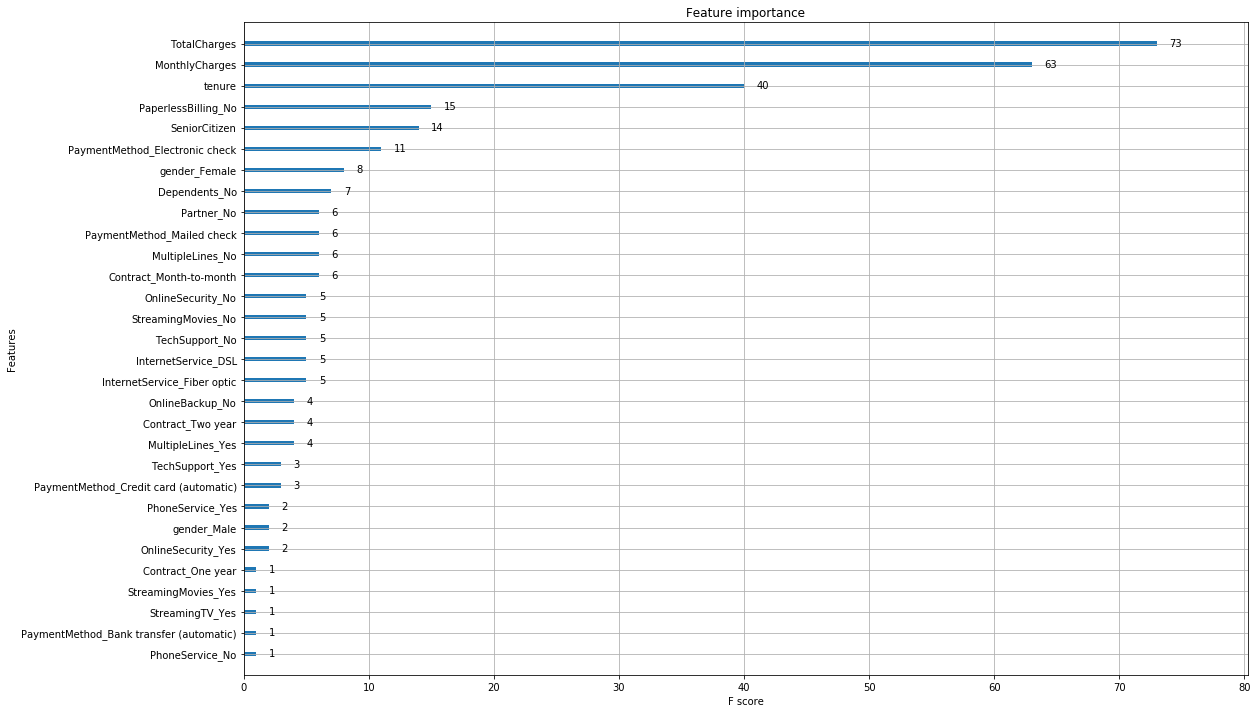

In [164]:
xgb.plot_importance(xgbmodel)
plt.rcParams['figure.figsize'] = [18, 12]
plt.show()